# Situation Report

So far we've created a model that is very overfit.  The plots have shown us that the validation metrics have very high variance and no real sign of convergence.  We're going to try a few different techniques to reduce the overfitting, including regularization, data augmentation, and possibly using batch normalization and dropout layers if necessary.

# Loading data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, os.path
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras_preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import scipy
from PIL import Image
from scipy import ndimage
import cv2
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras import optimizers
from keras.layers import BatchNormalization, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Preprocessing

In [2]:
# Directories
import pathlib as Path

train_dir = '../chest_xray/train'
validation_dir = '../chest_xray/val'
test_dir = '../chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 

# We'll prepare some data augmentation parameters for use later.
aug_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.15,
                                height_shift_range=0.15,
                                shear_range=0.1,
                                zoom_range=0.1,
                                vertical_flip=True,
                                fill_mode='nearest')

# Generating Data

train_gen = datagen.flow_from_directory(train_dir, 
                    # Increasing image resolution to 128x128 pixels
                    target_size=(128, 128),
                    batch_size=5216,
                    class_mode='binary')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(128, 128),
                    batch_size=16,
                    class_mode='binary')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(128, 128),
                    batch_size=624,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [36]:
# Checking the image shape
print('Train Image Shape: ', train_img.shape)
print('Train Labels Shape: ', train_labels.shape)

Train Image Shape:  (5216, 128, 128, 3)
Train Labels Shape:  (5216,)


# Tuning the Network

As mentioned above, the one thing that both of the previous models had in common was **high variance** in the **validation loss and accuracy scores**.  This suggests that the model is **too complex** and should be **simplified**.  Let's begin by **adding batch normalization** in each **Convolution** layer and **utilize Dropout** for our **Dense layers**.

In case that this ends up penalizing our model too much, we're going to **add padding**.

Also, let's experiment with **weight initializers**.  We'll utilize **He_Normal**, which **picks weights** from a **normalized distribution** and **assigns them to the features**. It also happens to work really well with our **ReLU** function, so that's a plus!

In [4]:
from keras import optimizers
from keras.layers import BatchNormalization, Activation

np.random.seed(42)

model3 = models.Sequential()

# Due to the amount of noise in our data, we'll use a smaller filter of 3x3

# Layer Block 1
model3.add(layers.Conv2D(32, (3,3), padding='same',
                         kernel_initializer='he_normal',
                        input_shape=(128, 128, 3)))
model3.add(layers.BatchNormalization())
model3.add(Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))

# Layer Block 2
model3.add(layers.Conv2D(64, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))

# Layer Block 3
model3.add(layers.Conv2D(128, (3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))

# Layer Block 4
model3.add(layers.Conv2D(128, (3,3), padding='same'))
model3.add(layers.BatchNormalization())
model3.add(Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))

# Layer Block 5
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.3))

# Layer Block 6
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.2))

# Output layer
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])


Let's go ahead and get a summary of the model.

In [5]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [6]:
history3 = model3.fit(train_img, train_labels,
                      batch_size=50,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)],
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 384s 74ms/step - loss: 4.0859 - acc: 0.7379 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 377s 72ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 381s 73ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/40
5216/5216 [==============================] - 383s 73ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/40
5216/5216 [==============================] - 389s 75ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/40
5216/5216 [==============================] - 375s 72ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000


Forty minutes and six epochs later and there was absolutely **no change** in the validation metrics.  Not to mention that there are still a lot of parameters.  Let's just see what happens when we add only the **kernel initializer** and reduce the number of nodes and filters.    

In [52]:
np.random.seed(42)

model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2,2)))

# Layer 2
model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Layer 3
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Layer 4
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))

# Output Layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        55360     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 16384)             0         
__________

A lot fewer parameters! Let's model it and see what happens.

In [53]:
history = model.fit(train_img, train_labels,
                      batch_size=50,
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 186s 36ms/step - loss: 0.4412 - acc: 0.7791 - val_loss: 0.5403 - val_acc: 0.7500
Epoch 2/40
5216/5216 [==============================] - 188s 36ms/step - loss: 0.2383 - acc: 0.9486 - val_loss: 0.7125 - val_acc: 0.6250
Epoch 3/40
5216/5216 [==============================] - 185s 35ms/step - loss: 0.2118 - acc: 0.9580 - val_loss: 0.5614 - val_acc: 0.6875
Epoch 4/40
5216/5216 [==============================] - 186s 36ms/step - loss: 0.1983 - acc: 0.9609 - val_loss: 0.3615 - val_acc: 0.9375
Epoch 5/40
5216/5216 [==============================] - 190s 36ms/step - loss: 0.1828 - acc: 0.9663 - val_loss: 0.4420 - val_acc: 0.8750
Epoch 6/40
5216/5216 [==============================] - 184s 35ms/step - loss: 0.1633 - acc: 0.9751 - val_loss: 0.3430 - val_acc: 0.8750
Epoch 7/40
5216/5216 [==============================] - 178s 34ms/step - loss: 0.1323 - acc: 0.9768 - val_loss: 0.8135 - val_acc: 0.

## Plot the performance

In [2]:
def plot_performance(model):
    """
    Input a trained model.
    
    Outputs plots of the Training and Validation accuracy and loss.  
    """
    
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'blue', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'red', label='Validation Accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'blue', label='Training Loss')
    plt.plot(epochs, val_loss, 'red', label='Validation Loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

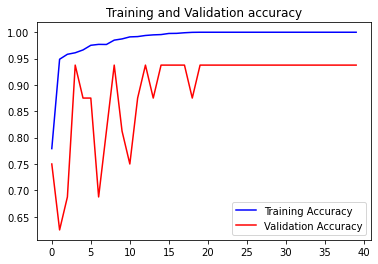

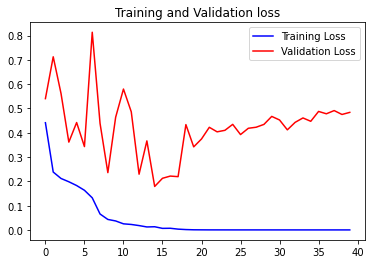

In [57]:
plot_performance(history)

In [58]:
results = model.evaluate(test_img, test_labels)

624/624 [==============================] - 7s 11ms/step


In [59]:
results

[3.2849259682190723, 0.7323717948717948]

## Evaluation:

Ok, obviously there is still overfitting.  However! The variance in Validation Accuracy reduced to the point that it actually converged!  Let's go ahead and really start addressing this overfitting. 

# Regularization

Let's try to use regularization.

**Changes to model:**

* Use He Normalizer in **each layer**; not just the first
* Set kernel_regularizer to L2 for each layer

In [7]:
np.random.seed(42)

model = models.Sequential()

# Adding Padding
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        input_shape=(128, 128, 3)))

model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(96, (3,3), padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                       activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        55360     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
__________

In [8]:
history = model.fit(train_img, train_labels,
                      batch_size=50,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)],
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 204s 39ms/step - loss: 3.3243 - acc: 0.8740 - val_loss: 2.3841 - val_acc: 0.7500
Epoch 2/40
5216/5216 [==============================] - 205s 39ms/step - loss: 1.6906 - acc: 0.9601 - val_loss: 1.4540 - val_acc: 1.0000
Epoch 3/40
5216/5216 [==============================] - 207s 40ms/step - loss: 1.1634 - acc: 0.9613 - val_loss: 1.1014 - val_acc: 0.8750
Epoch 4/40
5216/5216 [==============================] - 212s 41ms/step - loss: 0.8334 - acc: 0.9636 - val_loss: 1.1711 - val_acc: 0.6250
Epoch 5/40
5216/5216 [==============================] - 215s 41ms/step - loss: 0.6069 - acc: 0.9664 - val_loss: 1.0376 - val_acc: 0.6875
Epoch 6/40
5216/5216 [==============================] - 207s 40ms/step - loss: 0.4608 - acc: 0.9678 - val_loss: 0.6811 - val_acc: 0.8125
Epoch 7/40
5216/5216 [==============================] - 190s 37ms/step - loss: 0.3531 - acc: 0.9701 - val_loss: 0.4853 - val_acc: 0.

I can already see where that's going.  Accuracy is increasing way too fast. 95% accuracy after only two epochs? Regularization is **too light**. Let's try some **data augmentation**.

# Data Augmentation

In [3]:
train_dir = '../chest_xray/train'
validation_dir = '../chest_xray/val'
test_dir = '../chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 
aug_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.15,
                                height_shift_range=0.15,
                                shear_range=0.1,
                                zoom_range=0.1,
                                vertical_flip=True,
                                fill_mode='nearest')
# Generating Data

train_gen = aug_datagen.flow_from_directory(train_dir,
                    target_size=(128, 128),
                    batch_size=5216,
                    class_mode='binary')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(128, 128),
                    batch_size=16,
                    class_mode='binary')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(128, 128),
                    batch_size=624,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [13]:
np.random.seed(42)

model = models.Sequential()

# Let's take out the kernel initializer and see if that is a problem
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        input_shape=(128, 128, 3)))

model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(96, (3,3), padding='same', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), padding='same', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        55360     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
__________

In [14]:
history = model.fit(train_img, train_labels,
                      batch_size=50,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)],
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 195s 37ms/step - loss: 0.4661 - acc: 0.7851 - val_loss: 0.8447 - val_acc: 0.5625
Epoch 2/40
5216/5216 [==============================] - 196s 37ms/step - loss: 0.3182 - acc: 0.8533 - val_loss: 1.7328 - val_acc: 0.5625
Epoch 3/40
5216/5216 [==============================] - 197s 38ms/step - loss: 0.2570 - acc: 0.8884 - val_loss: 1.5811 - val_acc: 0.5625
Epoch 4/40
5216/5216 [==============================] - 191s 37ms/step - loss: 0.2252 - acc: 0.9051 - val_loss: 0.8073 - val_acc: 0.6875
Epoch 5/40
5216/5216 [==============================] - 196s 38ms/step - loss: 0.2014 - acc: 0.9156 - val_loss: 0.7316 - val_acc: 0.5625
Epoch 6/40
5216/5216 [==============================] - 198s 38ms/step - loss: 0.1679 - acc: 0.9350 - val_loss: 0.9358 - val_acc: 0.5625
Epoch 7/40
5216/5216 [==============================] - 195s 37ms/step - loss: 0.1452 - acc: 0.9413 - val_loss: 2.0673 - val_acc: 0.

Not only is the model learning way too fast, the validation loss is going all over the place.  If regularization and data augmentation aren't enough on their own, let's do both at the same time.

# Regularization & Data Augmentation

Seeing how removing the kernel initializer caused higher variance in our Validation loss, we'll add it back in along with our regularizer and keep the augmentation.

In [6]:
np.random.seed(42)

model = models.Sequential()


model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        input_shape=(128, 128, 3)))

model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(96, (3,3), padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, # kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                       activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        55360     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
__________

In [7]:
history_reg = model.fit(train_img, train_labels,
                      batch_size=50,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5)],
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 238s 46ms/step - loss: 2.6906 - acc: 0.7301 - val_loss: 2.1580 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 246s 47ms/step - loss: 1.5604 - acc: 0.7535 - val_loss: 1.7025 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 226s 43ms/step - loss: 1.0914 - acc: 0.7824 - val_loss: 1.1473 - val_acc: 0.8125
Epoch 4/40
5216/5216 [==============================] - 223s 43ms/step - loss: 0.8002 - acc: 0.8221 - val_loss: 1.0035 - val_acc: 0.6250
Epoch 5/40
5216/5216 [==============================] - 224s 43ms/step - loss: 0.6652 - acc: 0.8236 - val_loss: 0.9434 - val_acc: 0.6875
Epoch 6/40
5216/5216 [==============================] - 232s 44ms/step - loss: 0.5531 - acc: 0.8357 - val_loss: 0.8482 - val_acc: 0.6875
Epoch 7/40
5216/5216 [==============================] - 232s 44ms/step - loss: 0.5027 - acc: 0.8378 - val_loss: 0.7738 - val_acc: 0.

In [8]:
model.evaluate(test_img, test_labels)

624/624 [==============================] - 8s 13ms/step


[0.49801368438280547, 0.8028846153846154]

Okay! Assuming that I didn't end this too soon, the model appears to be underfitting.  Let's try to make the model more complex to offset this.

## Increasing Complexity

We're going to increase the number of filters in the Convolution layers and nodes in our Dense layer. 

In [19]:
np.random.seed(42)

model_augreg3 = models.Sequential()

model_augreg3.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        input_shape=(128, 128, 3)))
# model.add(layers.BatchNormalization())
model_augreg3.add(layers.MaxPooling2D((2,2)))


model_augreg3.add(layers.Conv2D(128, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_augreg3.add(layers.MaxPooling2D((2,2)))

model_augreg3.add(layers.Conv2D(256, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_augreg3.add(layers.MaxPooling2D((2,2)))

model_augreg3.add(layers.Flatten())
model_augreg3.add(layers.Dense(64, kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        activation='relu'))
# model.add(layers.Dropout(0.2))
model_augreg3.add(layers.Dense(1, activation='sigmoid'))

model_augreg3.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model_augreg3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 65536)             0         
__________

Because of how much variance is in the validation accuracy, we'll be generous with the patience parameter.

In [20]:
history_augreg3 = model_augreg3.fit(train_img, train_labels,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='acc',
                                         patience=3)],
                      batch_size=50,
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 322s 62ms/step - loss: 5.9736 - acc: 0.7404 - val_loss: 8.8679 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 317s 61ms/step - loss: 1.5740 - acc: 0.7341 - val_loss: 1.3121 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 319s 61ms/step - loss: 0.9091 - acc: 0.7429 - val_loss: 1.0188 - val_acc: 0.5000
Epoch 4/40
5216/5216 [==============================] - 323s 62ms/step - loss: 0.7339 - acc: 0.7431 - val_loss: 0.9066 - val_acc: 0.6875
Epoch 5/40
5216/5216 [==============================] - 315s 60ms/step - loss: 0.6399 - acc: 0.7488 - val_loss: 0.8189 - val_acc: 0.8125
Epoch 6/40
5216/5216 [==============================] - 321s 62ms/step - loss: 0.5757 - acc: 0.7709 - val_loss: 0.7896 - val_acc: 0.8750
Epoch 7/40
5216/5216 [==============================] - 322s 62ms/step - loss: 0.5272 - acc: 0.7987 - val_loss: 0.8884 - val_acc: 0.

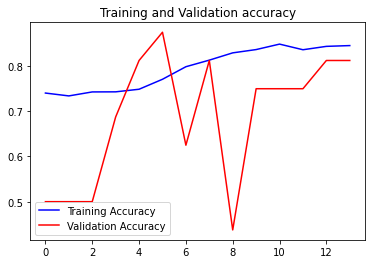

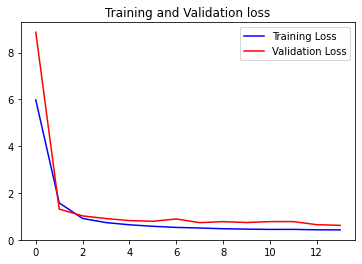

In [23]:
plot_performance(history_augreg3)

In [24]:
augreg_result_test = model_augreg3.evaluate(test_img, test_labels)
print(f"Model's Test Accuracy = {round((augreg_result_test[1]*100), 3)}%")
print(f"Model's Test Loss = {augreg_result_test[0]}")

624/624 [==============================] - 11s 18ms/step
Model's Test Accuracy = 77.244%
Model's Test Loss = 0.5277808812948374


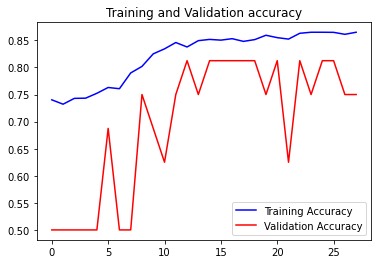

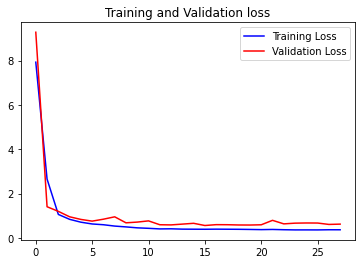

In [31]:
plot_performance(history_augreg3)

In [32]:
augreg_result_train = model_augreg3.evaluate(train_img, train_labels)
augreg_result_train

5216/5216 [==============================] - 80s 15ms/step


[0.3492514992052792, 0.879217791411043]

In [33]:
augreg_result_test = model_augreg3.evaluate(test_img, test_labels)
print(f"Model's Test Accuracy = {round((augreg_result_test[1]*100), 3)}%")
print(f"Model's Test Loss = {augreg_result_test[0]}")

624/624 [==============================] - 10s 16ms/step
Model's Test Accuracy = 79.006%
Model's Test Loss = 0.48309843968122435


### Evaluation:
Wow, that is a big improvement!  We still see some variance in our validation accuracy, but there is a huge improvement in the loss! Seeing how the training accuracy is continuing to increase, let's try to let this run for all 40 epochs.

## Attempt 2

In [25]:
np.random.seed(42)

model_augreg4 = models.Sequential()

model_augreg4.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model_augreg4.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        bias_regularizer='l2',
                        input_shape=(128, 128, 3)))

model_augreg4.add(layers.MaxPooling2D((2,2)))


model_augreg4.add(layers.Conv2D(128, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        bias_regularizer='l2',
                        kernel_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_augreg4.add(layers.MaxPooling2D((2,2)))

model_augreg4.add(layers.Conv2D(256, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        bias_regularizer='l2',
                        kernel_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_augreg4.add(layers.MaxPooling2D((2,2)))

model_augreg4.add(layers.Flatten())
model_augreg4.add(layers.Dense(64, kernel_initializer='he_normal',
                        bias_regularizer='l2',
                        kernel_regularizer='l2',
                        activation='relu'))
# model.add(layers.Dropout(0.2))
model_augreg4.add(layers.Dense(1, activation='sigmoid'))

model_augreg4.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model_augreg4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 65536)             0         
__________

In [26]:
history_augreg4 = model_augreg4.fit(train_img, train_labels,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=25)],
                      batch_size=50,
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 317s 61ms/step - loss: 5.9738 - acc: 0.7404 - val_loss: 8.8675 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 313s 60ms/step - loss: 1.5659 - acc: 0.7341 - val_loss: 1.2595 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 311s 60ms/step - loss: 0.9167 - acc: 0.7387 - val_loss: 1.0227 - val_acc: 0.6250
Epoch 4/40
5216/5216 [==============================] - 315s 60ms/step - loss: 0.7405 - acc: 0.7462 - val_loss: 0.9489 - val_acc: 0.5000
Epoch 5/40
5216/5216 [==============================] - 315s 60ms/step - loss: 0.6519 - acc: 0.7492 - val_loss: 0.8757 - val_acc: 0.5000
Epoch 6/40
5216/5216 [==============================] - 315s 60ms/step - loss: 0.5973 - acc: 0.7521 - val_loss: 0.8279 - val_acc: 0.5000
Epoch 7/40
5216/5216 [==============================] - 311s 60ms/step - loss: 0.5594 - acc: 0.7488 - val_loss: 0.8517 - val_acc: 0.

KeyboardInterrupt: 

In [39]:
augreg_result_train2 = model_augreg4.evaluate(train_img, train_labels)
augreg_result_train2

5216/5216 [==============================] - 80s 15ms/step


[0.28224409952119817, 0.9215874233128835]

In [40]:
augreg_result_test2 = model_augreg4.evaluate(test_img, test_labels)
print(f"Model's Test Accuracy = {round((augreg_result_test2[1]*100), 3)}%")
print(f"Model's Test Loss = {augreg_result_test2[0]}")

624/624 [==============================] - 9s 15ms/step
Model's Test Accuracy = 85.417%
Model's Test Loss = 0.3848557946009514


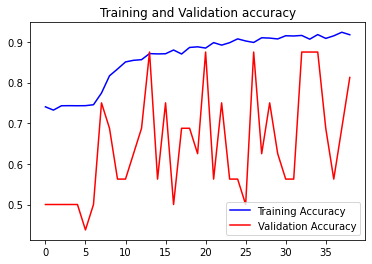

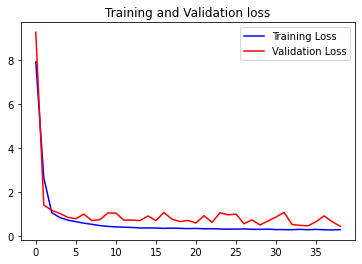

In [41]:
plot_performance(history_augreg4)

 WOW! I was hoping for an accuracy of 80%, but a leap up to 85%!?  I am a happy man right now!  We did only run it through 40 epochs, and it is possible that with more epochs, accuracy could have increased, but I didn't want to invest too much time into models that I wasn't positive had stabilized yet. 

Now that we have a more stable model template, let's try tuning hyperparameters to polish it up a tiny bit more.  

First, let's save the model we've got so far!

In [42]:
model_augreg4.save('chest_xray_augmented_regularized_data.h5')

# Transfer Architecture

Similar to "transfer learning" where we use a previously trained model to improve our machine learning model, we're going to use the general architecture of an existing model and try to improve our model performance.  We'll try to borrow the architecture of Xception, a high performance image recognition model, to improve ours.  Given, we aren't going to have so many layers, but keep the general idea of multiple Convolutional layers before our MaxPooling later.  

In [3]:
train_dir = '../chest_xray/chest_xray/train'
validation_dir = '../chest_xray/chest_xray/val'
test_dir = '../chest_xray/chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 
aug_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.15,
                                height_shift_range=0.15,
                                #shear_range=0.1,
                                #zoom_range=0.1,
                                #vertical_flip=True,
                                #fill_mode='nearest'
                                )
# Generating Data

train_gen = datagen.flow_from_directory(train_dir, 
                    # Starting with 128x128 pixel images; subject to change
                    target_size=(128, 128),
                    batch_size=5168,
                    class_mode='categorical')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(128, 128),
                    batch_size=113,
                    class_mode='categorical')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(128, 128),
                    batch_size=575,
                    class_mode='categorical')

Found 5168 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
Found 575 images belonging to 2 classes.


In [4]:
train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [5]:
from keras.layers import SeparableConv2D

np.random.seed(42)

model_augreg5 = models.Sequential()

# Layer 1
model_augreg5.add(layers.Conv2D(32, (3,3), padding='same', 
                        activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2',
                        input_shape=(128, 128, 3)))

model_augreg5.add(layers.BatchNormalization())

model_augreg5.add(layers.Conv2D(32, (3,3), activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.MaxPooling2D((2,2)))


# Layer 2
model_augreg5.add(layers.SeparableConv2D(64, (3,3), padding='same', 
                        activation='relu',
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.BatchNormalization())

model_augreg5.add(layers.SeparableConv2D(64, (3,3), 
                        activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.MaxPooling2D((2,2)))

# Layer 3
model_augreg5.add(layers.SeparableConv2D(96, (3,3), padding='same', 
                        activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.BatchNormalization())

model_augreg5.add(layers.SeparableConv2D(96, (3,3), padding='same', 
                        activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.MaxPooling2D((2,2)))

# layer 4
model_augreg5.add(layers.SeparableConv2D(128, (3,3), padding='same', 
                        activation='relu', 
                        dilation_rate=(2,2),
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.BatchNormalization())

model_augreg5.add(layers.SeparableConv2D(128, (3,3), 
                        activation='relu', 
                        #kernel_initializer='he_normal',
                        #kernel_regularizer='l2',
                        #bias_regularizer='l2'
                               ))

model_augreg5.add(layers.MaxPooling2D((2,2)))


# Layer 6
model_augreg5.add(layers.Flatten())

model_augreg5.add(layers.Dense(256, activation='relu', 
                        #kernel_initializer='he_normal',
                        #bias_regularizer='l2',
                        #kernel_regularizer='l2',
                        ))


model_augreg5.add(layers.Dense(64, activation='relu', 
                        #kernel_initializer='he_normal',
                        #bias_regularizer='l2',
                        #kernel_regularizer='l2',
                        ))


model_augreg5.add(layers.Dropout(0.4))

# Output
model_augreg5.add(layers.Dense(2, activation='softmax'))

model_augreg5.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model_augreg5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 63, 63, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 61, 61, 64)        4736      
__________

In [ ]:
history_augreg5 = model_augreg5.fit_generator(train_gen,
                              steps_per_epoch=326,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=16)

Epoch 1/20


In [6]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            patience=10),
             tf.keras.callbacks.ModelCheckpoint(
                filepath= '../Models and Data Analysis/best_checkpoint', 
                 monitor='val_loss', verbose=0, save_best_only=True,
                 save_weights_only=False, mode='auto')]


history_augreg6 = model_augreg5.fit(train_img, train_labels,
                      callbacks=callbacks,
                      batch_size=32,
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5168 samples, validate on 113 samples
Epoch 1/40
5168/5168 [==============================] - 630s 122ms/step - loss: 0.1875 - acc: 0.9245 - val_loss: 0.6764 - val_acc: 0.7345
Epoch 2/40
5168/5168 [==============================] - 632s 122ms/step - loss: 0.0829 - acc: 0.9714 - val_loss: 0.7635 - val_acc: 0.6372
Epoch 3/40
5168/5168 [==============================] - 637s 123ms/step - loss: 0.0605 - acc: 0.9791 - val_loss: 0.4950 - val_acc: 0.8319
Epoch 4/40
5168/5168 [==============================] - 635s 123ms/step - loss: 0.0445 - acc: 0.9841 - val_loss: 0.3711 - val_acc: 0.8142
Epoch 5/40
5168/5168 [==============================] - 635s 123ms/step - loss: 0.0374 - acc: 0.9861 - val_loss: 0.8389 - val_acc: 0.8319
Epoch 6/40
5168/5168 [==============================] - 637s 123ms/step - loss: 0.0349 - acc: 0.9870 - val_loss: 0.6297 - val_acc: 0.8319
Epoch 7/40
5168/5168 [==============================] - 632s 122ms/step - loss: 0.0340 - acc: 0.9876 - val_loss: 2.2426 - val

In [7]:
model = models.load_model('../Models and Data Analysis/best_checkpoint')

In [8]:
augreg_result_train3 = model.evaluate(train_img, train_labels)
augreg_result_train3

5168/5168 [==============================] - 222s 43ms/step


[0.18377362087876434, 0.9138931888544891]

In [9]:
augreg_result_test3 = model.evaluate(test_img, test_labels)
print(f"Model's Test Accuracy = {round((augreg_result_test3[1]*100), 3)}%")
print(f"Model's Test Loss = {augreg_result_test3[0]}")

575/575 [==============================] - 25s 43ms/step
Model's Test Accuracy = 88.174%
Model's Test Loss = 0.40666656696278114


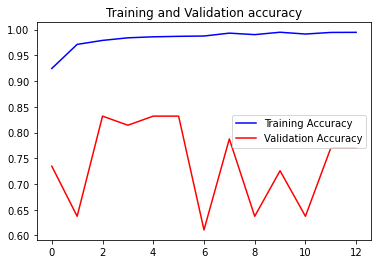

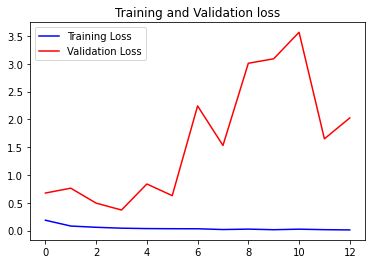

In [10]:
plot_performance(history_augreg6)

# Tuning Hyperparameters

For our initial change, we'll focus on the effect of **changing the learning rate of our optimizer**.  We will still lay the foundation for future parameter tuning, however.

Then we'll change the learning rate of our optimizer (Adam) to something a **little bigger** and add a **decay parameter**.

Note: I have commented out some more normalizing layers currently just to have it ready if the model begins to overfit again.

In [12]:
from keras import callbacks


np.random.seed(42)

# Initializing a callback to stop early 
callback = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)] # We'll be generous 
# Regularizer Tuning
reg_params = keras.regularizers.l2(1e-2)

# Optimizer
adam = keras.optimizers.Adam(lr=0.01, decay=1e-5)


model_opt = models.Sequential()

# We'll add in a stride parameter
model_opt.add(layers.Conv2D(64, (3,3), 
                        strides= 1, 
                        padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        input_shape=(128, 128, 3)))
# model.add(layers.BatchNormalization())
model_opt.add(layers.MaxPooling2D((2,2),
                                 strides=2))


model_opt.add(layers.Conv2D(128, (3,3), 
                        strides= 1,
                        padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_opt.add(layers.MaxPooling2D((2,2),
                                 strides=2))

model_opt.add(layers.Conv2D(256, (3,3), padding='same', 
                        strides=1,
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_opt.add(layers.MaxPooling2D((2,2),
                                 strides=2))

model_opt.add(layers.Flatten())
model_opt.add(layers.Dense(64, # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                       activation='relu'))
# model.add(layers.Dropout(0.2))
model_opt.add(layers.Dense(1, activation='sigmoid'))

model_opt.compile(loss='binary_crossentropy',
             optimizer=adam,
             metrics=['acc'])
model_opt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
__________

In [13]:
history_opt = model_opt.fit(train_img, train_labels,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)],
                        batch_size=50,
                        epochs=40, 
                        validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 259s 50ms/step - loss: 11.8269 - acc: 0.7040 - val_loss: 13.1972 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 256s 49ms/step - loss: 15.8358 - acc: 0.3345 - val_loss: 11.0294 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 253s 48ms/step - loss: 13.4721 - acc: 0.2571 - val_loss: 8.6776 - val_acc: 0.5000
Epoch 4/40
5216/5216 [==============================] - 254s 49ms/step - loss: 25.6851 - acc: 0.4530 - val_loss: 45.6010 - val_acc: 0.5000
Epoch 5/40
5216/5216 [==============================] - 259s 50ms/step - loss: 17.9173 - acc: 0.7337 - val_loss: 5.3198 - val_acc: 0.5000
Epoch 6/40
5216/5216 [==============================] - 259s 50ms/step - loss: 2.5928 - acc: 0.7429 - val_loss: 1.4833 - val_acc: 0.5000


Looks like our model is **underfit again**.  Perhaps, I made too many changes at once. Let's go ahead and change the learning rate back to the default (0.001) and see what happens when we keep the decay.

In [18]:
# Initializing a callback to stop early 
callback = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)] # We'll be generous 
# Regularizer Tuning
reg_params = keras.regularizers.l2(1e-2)

# Optimizer
adam = keras.optimizers.Adam(lr=0.001, decay=1e-5)


model_opt3 = models.Sequential()

# We'll add in a stride parameter and increase it once
model_opt3.add(layers.Conv2D(64, (3,3), 
                        strides= 1, 
                        padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        input_shape=(128, 128, 3)))
# model.add(layers.BatchNormalization())
model_opt3.add(layers.MaxPooling2D((2,2), strides=2))


model_opt3.add(layers.Conv2D(128, (3,3), 
                        strides= 1,
                        padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_opt3.add(layers.MaxPooling2D((2,2), strides=2))

model_opt3.add(layers.Conv2D(256, (3,3), padding='same', 
                        strides= 1,
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_opt3.add(layers.MaxPooling2D((2,2), strides=2))

model_opt3.add(layers.Flatten())
model_opt3.add(layers.Dense(64, # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                       activation='relu'))
# model.add(layers.Dropout(0.2))
model_opt3.add(layers.Dense(1, activation='sigmoid'))

model_opt3.compile(loss='binary_crossentropy',
             optimizer=adam,
             metrics=['acc'])
model_opt3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 65536)             0         
__________

In [19]:
history_opt2 = model_opt3.fit(train_img, train_labels,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=9)],
                        batch_size=50,
                        epochs=40, 
                        validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 254s 49ms/step - loss: 13.2308 - acc: 0.3518 - val_loss: 2.1394 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 253s 48ms/step - loss: 1.5162 - acc: 0.7327 - val_loss: 1.4688 - val_acc: 0.4375
Epoch 3/40
5216/5216 [==============================] - 254s 49ms/step - loss: 1.0385 - acc: 0.7506 - val_loss: 1.1184 - val_acc: 0.5625
Epoch 4/40
5216/5216 [==============================] - 273s 52ms/step - loss: 0.8339 - acc: 0.7684 - val_loss: 1.2539 - val_acc: 0.5000
Epoch 5/40
5216/5216 [==============================] - 268s 51ms/step - loss: 0.6976 - acc: 0.7866 - val_loss: 0.8605 - val_acc: 0.8750
Epoch 6/40
5216/5216 [==============================] - 281s 54ms/step - loss: 0.6039 - acc: 0.8098 - val_loss: 0.7921 - val_acc: 0.8750
Epoch 7/40
5216/5216 [==============================] - 291s 56ms/step - loss: 0.5584 - acc: 0.8125 - val_loss: 0.7431 - val_acc: 0

In [20]:
model_opt2.evaluate(test_img, test_labels)

624/624 [==============================] - 10s 16ms/step


[0.7787722777097653, 0.6233974358974359]

Very interesting! Our loss score is terrible, but if we look at the each epoch, the loss is decreasing consistently.

**Note: We've run the training data several times and saw that learning rates above 0.001 and inclusion of learning rate decay decreased model performance in it's present state.**

Let's move on and try decreasing our learning rate to 0.0001.

In [9]:
# Initializing a callback to stop early 
callback = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=5)] # We'll be generous 
# Regularizer Tuning
reg_params = keras.regularizers.l2(1e-2)

# Optimizer
adam = keras.optimizers.Adam(lr=0.0001)


model = models.Sequential()

# We'll add in a stride parameter and increase it once
model.add(layers.Conv2D(64, (3,3), 
                        strides= 1, 
                        padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        input_shape=(128, 128, 3)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2), strides=2))


model.add(layers.Conv2D(128, (3,3), 
                        strides= 1,
                        padding='same', 
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2), strides=2))

model.add(layers.Conv2D(256, (3,3), padding='same', 
                        strides= 1,
                        # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                        activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, # kernel_initializer='he_normal',
                        kernel_regularizer=reg_params,
                       activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=adam,
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
__________

In [11]:
history_reg = model.fit(train_img, train_labels,
                        #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                        # Increasing patience to prevent early stopping unless 
                                                            # we've plateaued                 
                        #patience=2)],
                        batch_size=50,
                        epochs=40, 
                        validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 264s 51ms/step - loss: 9.2241 - acc: 0.8629 - val_loss: 8.3315 - val_acc: 0.6250
Epoch 2/40
5216/5216 [==============================] - 263s 50ms/step - loss: 7.1290 - acc: 0.9559 - val_loss: 6.9886 - val_acc: 0.6250
Epoch 3/40
5216/5216 [==============================] - 270s 52ms/step - loss: 5.8566 - acc: 0.9674 - val_loss: 5.4803 - val_acc: 0.9375
Epoch 4/40
5216/5216 [==============================] - 274s 53ms/step - loss: 4.8884 - acc: 0.9674 - val_loss: 4.6703 - val_acc: 0.8125
Epoch 5/40
5216/5216 [==============================] - 272s 52ms/step - loss: 4.1368 - acc: 0.9711 - val_loss: 4.4013 - val_acc: 0.6250
Epoch 6/40
5216/5216 [==============================] - 261s 50ms/step - loss: 3.5440 - acc: 0.9711 - val_loss: 3.4778 - val_acc: 0.9375
Epoch 7/40
5216/5216 [==============================] - 252s 48ms/step - loss: 3.0675 - acc: 0.9722 - val_loss: 3.1142 - val_acc: 0.

In [12]:
results_reg = model.evaluate(test_img, test_labels)

624/624 [==============================] - 9s 15ms/step


In [13]:
results_reg

[1.1064472947365198, 0.7307692307692307]

## Results: 
A learning rate of 0.0001 has resulted in a large step backwards.

It appears that we've reached **peak performance with Model_AugReg4**.  We can't increase accuracy without **dancing between an underfit model and an overfit model**.  Let's try to use Transfer Learning.

# Transfer Learning

Keras as many pretrained models that we can choose from and add on some dense layers to the top that we'll train specifically to our dataset.   

We'll use **Xception** since it has been trained on millions of images that belong to thousands of categories from the ImageNet dataset.  One core feature of this model is that it **utilizes Depthwise Separable Convolutions**.  These convolution layers **reduce the amount of multipliers** which, in turn, **keeps the model from becoming too complex**. Xception is also a very high performing model, so that will hopefully give us a little boost.


In [5]:
from keras.applications import Xception

In [6]:
# Loading Xception
cnn_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

In [7]:
cnn_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

We'll be adding our own top to this.  According to our summary here, the final layer of Xception will have an **output shape** of (x, 4, 4, 2048), so we'll make sure that we create a layer that will accommodate that.

In [13]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 4, 4, 2048)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(128, 128), 
        batch_size = 50, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [ ]:
# Creating features and labels

train_features, train_labels = extract_features(train_folder, 5216) 
validation_features, validation_labels = extract_features(val_folder, 200) 
test_features, test_labels = extract_features(test_folder, 180)

train_features = np.reshape(train_features, (540, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (200, 2 * 2 * 512))
test_features = np.reshape(test_features, (180, 2 * 2 * 512))

In [8]:
train_dir = '../chest_xray/train'
validation_dir = '../chest_xray/val'
test_dir = '../chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 
aug_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.15,
                                height_shift_range=0.15,
                                shear_range=0.1,
                                zoom_range=0.1,
                                vertical_flip=True,
                                fill_mode='nearest')
# Generating Data

train_gen = aug_datagen.flow_from_directory(train_dir, 
                    # Starting with 128x128 pixel images; subject to change
                    target_size=(128, 128),
                    batch_size=20,
                    class_mode='binary')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(128, 128),
                    batch_size=16,
                    class_mode='binary')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(128, 128),
                    batch_size=624,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
x_model = models.Sequential()

# Xception Base
x_model.add(cnn_base)

# Layer 1
x_model.add(layers.Flatten())
x_model.add(layers.Dense(1024, activation='relu', input_dim=4*4*2048))

# Layer 2
x_model.add(layers.Dense(512, activation='relu'))

# Output Layer
x_model.add(layers.Dense(1, activation='sigmoid'))

# Check to see if the Xception model is frozen
for layer in x_model.layers:
    print(layer.name, layer.trainable)

xception True
flatten_1 True
dense_1 True
dense_2 True
dense_3 True


In [10]:
# Freezing Xception
cnn_base.trainable = False

In [11]:
# Check to see if the Xception model is frozen
for layer in x_model.layers:
    print(layer.name, layer.trainable)

xception False
flatten_1 True
dense_1 True
dense_2 True
dense_3 True


In [12]:
x_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [13]:
history_x = x_model.fit_generator(train_gen,
                              steps_per_epoch=104,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=10)

Epoch 1/20
104/104 [==============================] - 311s 3s/step - loss: 2.5530 - acc: 0.7486 - val_loss: 4.1089 - val_acc: 0.5000
Epoch 2/20
104/104 [==============================] - 311s 3s/step - loss: 0.5341 - acc: 0.8274 - val_loss: 1.8595 - val_acc: 0.6250
Epoch 3/20
104/104 [==============================] - 319s 3s/step - loss: 0.4235 - acc: 0.8380 - val_loss: 0.4978 - val_acc: 0.6875
Epoch 4/20
104/104 [==============================] - 316s 3s/step - loss: 0.2988 - acc: 0.8784 - val_loss: 1.2855 - val_acc: 0.6250
Epoch 5/20
104/104 [==============================] - 314s 3s/step - loss: 0.3164 - acc: 0.8775 - val_loss: 1.1599 - val_acc: 0.6250
Epoch 6/20
104/104 [==============================] - 316s 3s/step - loss: 0.3170 - acc: 0.8712 - val_loss: 1.0195 - val_acc: 0.6250
Epoch 7/20
104/104 [==============================] - 315s 3s/step - loss: 0.2868 - acc: 0.8917 - val_loss: 2.6969 - val_acc: 0.5625
Epoch 8/20
104/104 [==============================] - 313s 3s/step - 

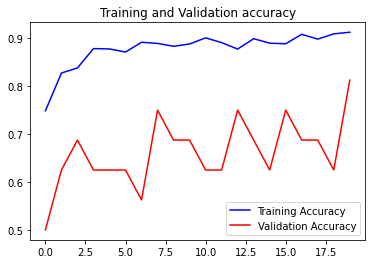

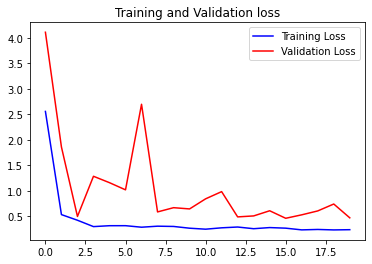

In [16]:
plot_performance(history_x)

In [17]:
train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [18]:
x_results_train = x_model.evaluate(train_img, train_labels)
x_results_train

20/20 [==============================] - 3s 168ms/step


[0.5054544806480408, 0.75]

In [19]:
x_results_test = x_model.evaluate(test_img, test_labels)
x_results_test

624/624 [==============================] - 107s 171ms/step


[0.5577453405429156, 0.7580128205128205]

## Evaluation:

Although there is more in our usual metrics, there does seem to be some signs of convergence if we left it running.  Despite this, the test accuracy is nothing to write home about, even when you look at the results of the final epoch which are pretty decent.  

For now, we'll just consider Model_AugReg4 as the best model to date and move on to some analysis.

**See Modeling Book 3 for Analysis**